In [1]:
%load_ext autoreload
%autoreload 1

#get our environment ready for data analysis times
%pylab inline

#import some os functionality so that we can be platform independent
import os

#import skimage components
from skimage.external import tifffile as tif #note that this can be achieved by using the
                                                #skimage.io with the tifffile plugin.
#better filtering than skimage
from scipy import ndimage

#import pandas
import pandas as pd

from scipy.ndimage import measurements
from scipy.ndimage.filters import median_filter

import matplotlib.gridspec as gridspec #fancy subplot layout

from matplotlib.path import Path #Needed to create shapes
import matplotlib.patches as patches #needed so show shapes on top of graphs

%aimport peaks.stackanalysis
PSFStackAnalyzer = peaks.stackanalysis.PSFStackAnalyzer

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = tif.imread(os.path.join('..','fixtures','CS5_pos2_newwin_PSF_R.tif'))

C:\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile_local.py:1394: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


In [3]:
from dphplotting.mip import mip

(<matplotlib.figure.Figure at 0x4b3a588>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000AF6DCC0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000C809B00>], dtype=object))

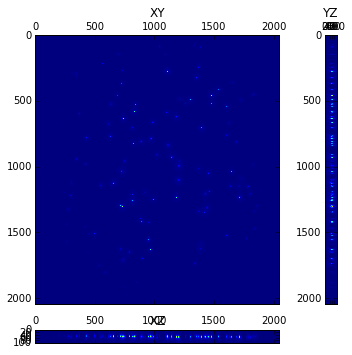

In [4]:
mip(data)

In [5]:
psf = PSFStackAnalyzer(data)

(<matplotlib.figure.Figure at 0x4b3a710>,
 <matplotlib.axes._subplots.AxesSubplot at 0xc8a8ef0>)

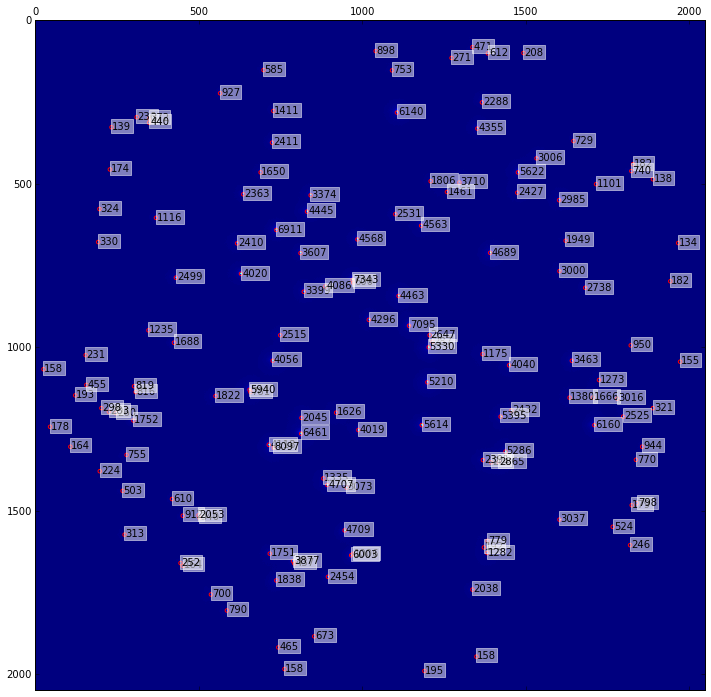

In [6]:
psf.peakfinder.plot_blobs()

In [27]:
times_size = {}
for j in range(5,45,5):
    times_size[j] = []
    for i in range(1,11):
        t = %timeit -r1 -n1 -o psf.fit_peaks(j, i)
        times_size[j].append(t.best)

1 loop, best of 1: 25.1 s per loop
1 loop, best of 1: 16.1 s per loop
1 loop, best of 1: 13.2 s per loop
1 loop, best of 1: 11.5 s per loop
1 loop, best of 1: 10.6 s per loop
1 loop, best of 1: 10.3 s per loop
1 loop, best of 1: 9.78 s per loop
1 loop, best of 1: 9.88 s per loop
1 loop, best of 1: 9.61 s per loop
1 loop, best of 1: 9.59 s per loop
1 loop, best of 1: 32.8 s per loop
1 loop, best of 1: 19.8 s per loop
1 loop, best of 1: 15.6 s per loop
1 loop, best of 1: 12.9 s per loop
1 loop, best of 1: 11.9 s per loop
1 loop, best of 1: 11.1 s per loop
1 loop, best of 1: 10.7 s per loop
1 loop, best of 1: 10.6 s per loop
1 loop, best of 1: 10.1 s per loop
1 loop, best of 1: 9.85 s per loop
1 loop, best of 1: 46.8 s per loop
1 loop, best of 1: 26.8 s per loop
1 loop, best of 1: 20.1 s per loop
1 loop, best of 1: 16.6 s per loop
1 loop, best of 1: 14.8 s per loop
1 loop, best of 1: 13.6 s per loop
1 loop, best of 1: 13 s per loop
1 loop, best of 1: 12.9 s per loop
1 loop, best of 1: 12.

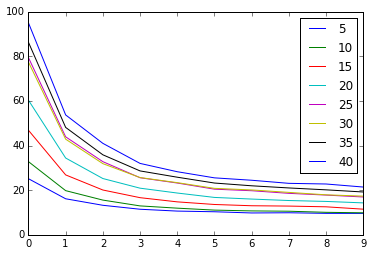

In [32]:
for k, v in sorted(times_size.items()):
    plot(v, label=k)
    
legend()

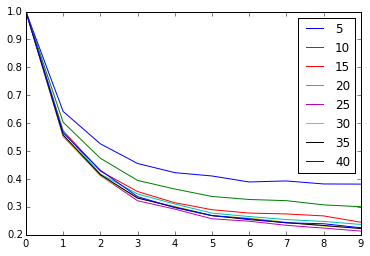

In [31]:
for k, v in sorted(times_size.items()):
    vv = array(v)
    plot(vv/vv.max(), label=k)
    
legend()

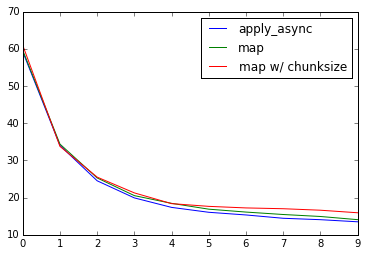

In [25]:
plot(times, label='apply_async')
plot(times2, label = 'map')
plot(times3, label = 'map w/ chunksize')
legend()

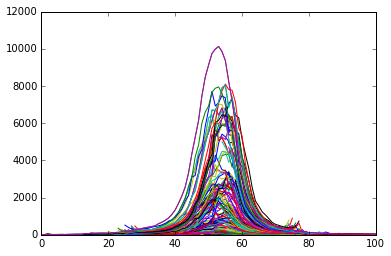

In [33]:
for fit in psf.fits:
    fit.amp.plot()

It looks like this method works, but we could probably speed things up, and get them to go much faster if we assumed that the beads don't move too much during the measurement.

This is a good assumption for the PSFs and the SIM stacks.

Therefore, it will be a good idea to make this algorithm specific to `DriftStackAnalyzer` and then have SIM and PSF essentially the same except for the order in which the stacks are iterated through:
- SIMStack will be iterated in order
- for each bead in PSF stack the iteration will branch out from the max point.

In both of those cases a "column" will be extracted from the overall data set, encapsulated in specialized object and sent out to be processed. Each object will return a pandas DataFrame for the fit.

Data transfer to the workers will be relatively slow, but its all being done at once which will hopefully mean lower overhead. Also the processing won't be interrupted by forward and backwards transfer.